# Library

In [42]:
import pandas as pd
import nltk
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json
import re
import emoji
import numpy as np

from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from bahasa.stemmer import Stemmer

from nltk.stem.snowball import SnowballStemmer
from nlp_id.lemmatizer import Lemmatizer

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set('indonesian') 



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rowjak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load & Understand Dataset

In [43]:
project_path = os.getcwd()

dataset_path = "dataset"
dictionary_path = "dictionary"
dataset_name = "tweet.csv"

df = pd.read_csv(os.path.join(project_path,dataset_path,dataset_name),encoding='UTF-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1815 non-null   int64 
 1   sentimen    1815 non-null   object
 2   tweet       1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB


In [44]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,sentimen,tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [45]:
df.isna().sum()/len(df)

sentimen    0.0
tweet       0.0
dtype: float64

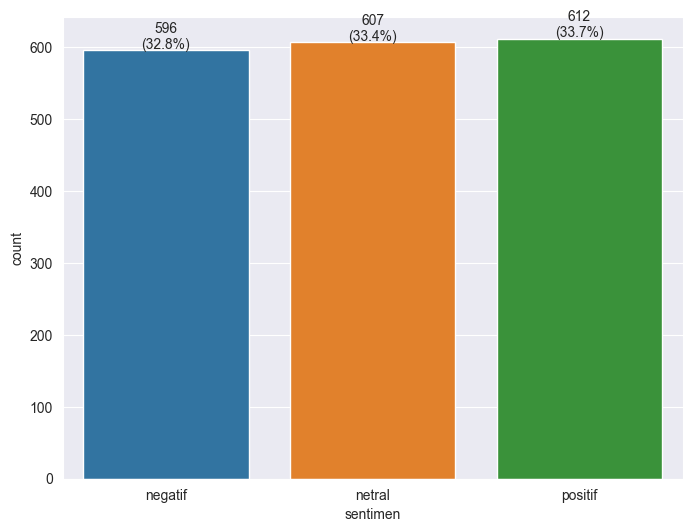

In [46]:
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.countplot(data=df, x='sentimen', hue='sentimen')
total = float(len(df))

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}\n({height/total:.1%})', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), textcoords='offset points')

plt.show()

label sentimen yang ada cukup balance, sehingga tidak memerlukan oversampling maupun undersampling.

In [47]:
print('Jumlah Data : ',len(df))

df = df.drop_duplicates()
print('Jumlah Data setelah menghapus data duplikat :', len(df))

Jumlah Data :  1815
Jumlah Data setelah menghapus data duplikat : 1815


## Text Preprocessing

*   Merubah tweet menjadi huruf kecil
*   Merubah emoji menjadi kata yang bermakna
*   Menghapus tanda baca
*   Menghapus karakter khusus
*   Menghapus Hashtag(#), username , @, dan url
*   Menghapus stopwords
*   Menghapus spasi berlebih
*   Merubah slangwords ke kata asli







In [48]:
with open(os.path.join(project_path, dictionary_path, 'combined_slang_words.json'), 'r') as json_file:
    slang_words_dict = json.load(json_file)
    
exc_stopwords = [
    'tidak', 'tak', 'belum', 'bukan', 'tanpa', 'jarang', 'kurang',
    'baik', 'bisa', 'mungkin', 'boleh', 'masalah'
]
    
def clean_and_process_text(text):
    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'pic\.twitter\.com/\S+', '', text)
    
    # Menghapus username dan hashtag
    text = re.sub(r'@(prabowo|sandi|jokowi)', r'\1', text)  
    text = re.sub(r'@\w+|#\w+', '', text)  
    
    # Ganti tanda baca dan karakter khusus dengan spasi
    text = re.sub(r'[^\w\s]', ' ', text)  # Mengganti dengan spasi
    text = re.sub(r'\d+', '', text)  # Menghapus angka
    
    # Hapus spasi lebih dari satu
    text = re.sub(r'\s+', ' ', text)  # Mengganti beberapa spasi dengan satu spasi
    
    # Mengubah ke huruf kecil dan tokenisasi
    text = text.lower().split()
    
    # Menghapus stopwords menggunakan Sastrawi
    stopword_factory = StopWordRemoverFactory()
    stop_words = set(stopword_factory.get_stop_words())
    
    # Gabungkan stopwords dengan kata yang dikecualikan
    stop_words = stop_words - set(exc_stopwords)  # Hapus kata yang dikecualikan dari stopwords
    
    # Saring kata-kata
    text = [word for word in text if word not in stop_words]
    
    # Kompilasi regex untuk mencocokkan kata-kata slang
    slang_words_regex = re.compile(r'\b(?:' + '|'.join(re.escape(word) for word in slang_words_dict.keys()) + r')\b')
    
    # Mengganti kata-kata slang
    text = ' '.join(text)  # Menggabungkan kembali list kata menjadi string
    text = slang_words_regex.sub(lambda match: slang_words_dict[match.group()], text)
    
    return text

# Menerapkan fungsi pembersihan dan pemrosesan pada kolom 'tweet_no_extra_space'
df['tweet_clean'] = df['tweet'].apply(clean_and_process_text)

In [49]:
df[['tweet','tweet_clean']].head(15)

,tweet,tweet_clean
0,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata prabowo indonesia tidak dihargai bangsa a...
1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...
2,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia semakin baik
3,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak pada ek...
4,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang buat bngun infrastruktur sudah ...
5,"Yg bisikin pak jokowi, cm mikirin perputaran d...",yang bisikin pak jokowi cm mikirin perputaran ...
6,Masa tenang msih ngoceh aja..ttp jokowi harga ...,masa tenang msih ngoceh saja ttp jokowi harga ...
7,#UASdifitnahKejiBalasDiTPS kerjasa ekonomi b...,kerjasa ekonomi bilateral multilateral doakan ...
8,"Iya bener Aa, kita MANTAP kan pilihan ke Pemim...",iya benar aa mantap kan pilihan pemimpin yang ...
9,Prabowo-Sandi Sepakat Tak Ambil Gaji karena Ne...,prabowo sandi sepakat tidak ambil gaji negara ...


## Text Normalization

In [50]:
# Inisialisasi stemmer Sastrawi
stemmer = Stemmer()

# Terapkan stemming
df['tweet_stemming'] = df['tweet_clean'].apply(lambda x: stemmer.stem(x))

In [51]:
# Inisialisasi lemmatizer
lemmatizer = Lemmatizer()

# Terapkan lemmatization langsung dalam lambda
df['tweet_lemmatized'] = df['tweet_clean'].apply(
    lambda text: ' '.join(lemmatizer.lemmatize(word) for word in text.split())
)

In [52]:
df['tweet_tokenize'] = df['tweet_lemmatized'].apply(word_tokenize)

In [84]:
# Ambil 10 baris secara acak
random_sample = df.sample(n=20, random_state=1)  # random_state untuk konsistensi hasil
for index, row in random_sample.iterrows():
    print(f"Index: {index}")
    print(f"Asli: {row['tweet']}")
    print(f"Stemming: {row['tweet_stemming']}")
    print(f"Lemmatized: {row['tweet_lemmatized']}")
    print(f"Tokenize: {row['tweet_tokenize']}")
    print(f"Sentimen: {row['sentimen']}")
    print("-" * 100)  # Pembatas antar tweet

Index: 596
Asli: Berita yang menyalahkan SBY sebagai salah satu pembuat kesalahan dalam perekonomian Indonesia, Mungkin sebaiknya hal tersebut tidak disebut Prabowo ke muka publik. Suatu kesalahan yang terlihat konyol.  http://cnn.id/386111Â 
Stemming: berita yang salah sby bagai salah satu buat salah dalam ekonomi indonesia mungkin baik hal sebut tidak sebut prabowo ke muka publik suatu salah yang lihat konyol
Lemmatized: berita yang salah sby bagai salah satu buat salah dalam ekonomi indonesia mungkin baik hal sebut tidak sebut prabowo ke muka publik suatu salah yang lihat konyol
Tokenize: ['berita', 'salah', 'sby', 'salah', 'satu', 'buat', 'salah', 'ekonomi', 'indonesia', 'mungkin', 'baik', 'sebut', 'tidak', 'sebut', 'prabowo', 'muka', 'publik', 'suatu', 'salah', 'lihat', 'konyol']
Sentimen: negatif
----------------------------------------------------------------------------------------------------
Index: 972
Asli: Pak @jokowi menwarkan Program Membina Ekonomi Keluarga Sejahtera (Me

## Hasil dari Preprocessing & Text Normalization

*   Semua data terjadi perubahan dari text preprocessing
*   Meskipun telah dicoba dengan Lematisasi dan Stemming, Tim Lebih memilih menggunakan lematisasi karena lebih akurat dalam mempertahankan makna



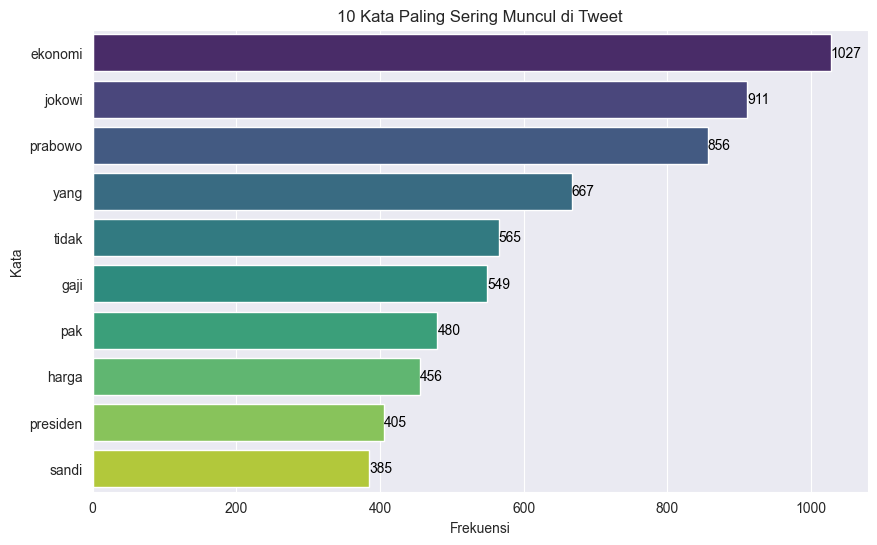

In [54]:
from collections import Counter
text = list(df['tweet_lemmatized'])

words = []
for line in text:
    words.extend(line.split())

# Menghitung jumlah kata
words_count = Counter(words)

# Ambil kata yang paling sering muncul
most_common_words = words_count.most_common(10)

# Buat DataFrame untuk visualisasi
most_common_df = pd.DataFrame(most_common_words, columns=['word', 'count'])

# Menambahkan kolom persentase
total_words = sum(words_count.values())
most_common_df['percentage'] = (most_common_df['count'] / total_words) * 100

# Visualisasi dengan seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=most_common_df, palette='viridis', hue='word', legend=False)

# Menambahkan label jumlah dan persentase di dalam bar
for i in range(len(most_common_df)):
    count = most_common_df['count'][i]
    plt.text(count, i, f'{count}', color='black', va='center')

# Menambahkan judul dan label
plt.title('10 Kata Paling Sering Muncul di Tweet')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')

plt.show()

In [55]:
# Buat DataFrame untuk memetakan kata dan sentimen
word_sentiments = []
for idx, row in df.iterrows():
    words_in_tweet = row['tweet_lemmatized'].split()
    for word in words_in_tweet:
        if word in most_common_df['word'].values:
            word_sentiments.append({'word': word, 'sentimen': row['sentimen']})

# Buat DataFrame dari hasil word_sentiments
word_sentiments_df = pd.DataFrame(word_sentiments)

# Buat pivot table
pivot = pd.pivot_table(word_sentiments_df, index='word', columns='sentimen', aggfunc='size', fill_value=0)

# Hitung total tweet per kata
pivot['Jml_Tweet'] = pivot.sum(axis=1)

# Hitung persentase per sentimen
pivot['% Ngtf'] = round((pivot.get('negatif', 0) / pivot['Jml_Tweet']) * 100,2)
pivot['% Netr'] = round((pivot.get('netral', 0) / pivot['Jml_Tweet']) * 100,2)
pivot['% Pstf'] = round((pivot.get('positif', 0) / pivot['Jml_Tweet']) * 100,2)

# Urutkan berdasarkan total tweet terbanyak
pivot = pivot.sort_values(by='Jml_Tweet', ascending=False)

# Atur ulang urutan kolom: Total_Tweets sebelum sentimen negatif, netral, positif
pivot = pivot[['Jml_Tweet', 'positif', 'netral', 'negatif', '% Ngtf', '% Netr', '% Pstf']]

# Cetak pivot table
print(pivot)

sentimen  Jml_Tweet  positif  netral  negatif  % Ngtf  % Netr  % Pstf
word                                                                 
ekonomi        1027      294     369      364   35.44   35.93   28.63
jokowi          911      320     329      262   28.76   36.11   35.13
prabowo         856      318     304      234   27.34   35.51   37.15
yang            667      252     127      288   43.18   19.04   37.78
tidak           565      198     185      182   32.21   32.74   35.04
gaji            549      227     153      169   30.78   27.87   41.35
pak             480      217      87      176   36.67   18.12   45.21
harga           456      170     148      138   30.26   32.46   37.28
presiden        405      144     132      129   31.85   32.59   35.56
sandi           385      160     151       74   19.22   39.22   41.56


In [56]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pickle

In [78]:
def tokenize(tweet):
    return nltk.word_tokenize(tweet.lower())

df['cleaned_tweet'] = df['tweet_stemming'].apply(tokenize)

# Step 3: Word2Vec - Training a Word2Vec model (Skipgram)
sentences = df['cleaned_tweet'].tolist()


In [79]:
print(df['cleaned_tweet'].head())

0    [kata, prabowo, indonesia, tidak, harga, bangs...
1    [batu, langka, tasbih, jokowi, hadiah, dari, h...
2    [di, era, jokowi, ekonomi, indonesia, makin, b...
3    [bagi, sumatera, selatan, asi, games, dampak, ...
4    [negara, kita, ngutang, buat, bngun, infrastru...
Name: cleaned_tweet, dtype: object


In [80]:
w2v_model = Word2Vec(sentences, vector_size=100, window=6, sg=1, min_count=1)

def get_vector_representation(tweet, model, vector_size=100):
    vectors = [model.wv[word] for word in tweet if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

df['tweet_vector'] = df['cleaned_tweet'].apply(lambda x: get_vector_representation(x, w2v_model))

# Step 4: Prepare train, validation, test sets
X = np.vstack(df['tweet_vector'].values)
y = df['sentimen']  # Target column for sentiment

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 6: Hyperparameter tuning with GridSearchCV for RandomForest (with reduced complexity)
param_grid = {
    'n_estimators': [100, 300],            # Reduce the number of trees
    'max_depth': [10, 50],               # Limit the depth of the trees
    'min_samples_split': [0.04, 0.08],        # Increase the minimum samples required to split a node
    'min_samples_leaf': [0.01, 0.02],         # Increase the minimum samples at a leaf node
    'max_features': ['sqrt'],             # Limit the number of features considered at each split
    'bootstrap': [True],
    'oob_score': [True],                  # Use Out-of-Bag samples for validation
}

rf = RandomForestClassifier(random_state=42)

# GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Step 7: Get the best model after tuning
best_rf = grid_search.best_estimator_

# Step 8: Model Evaluation on Train, Val, Test sets
y_train_pred = best_rf.predict(X_train_scaled)
y_val_pred = best_rf.predict(X_val_scaled)
y_test_pred = best_rf.predict(X_test_scaled)

# Step 9: Print accuracy for train, val, and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Print classification reports
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Validation):\n", classification_report(y_val, y_val_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

# Check OOB Score
print("Out-of-Bag Score:", best_rf.oob_score_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Train Accuracy: 69.76%
Validation Accuracy: 57.35%
Test Accuracy: 58.24%

Classification Report (Train):
               precision    recall  f1-score   support

     negatif       0.66      0.83      0.73       429
      netral       0.74      0.70      0.72       438
     positif       0.72      0.56      0.63       403

    accuracy                           0.70      1270
   macro avg       0.70      0.69      0.69      1270
weighted avg       0.70      0.70      0.69      1270


Classification Report (Validation):
               precision    recall  f1-score   support

     negatif       0.54      0.67      0.60        85
      netral       0.53      0.63      0.58        75
     positif       0.66      0.46      0.54       112

    accuracy                           0.57       272
   macro avg       0.58      0.59      0.57       272
weighted avg       0.59      0.57      0.57       272


Classification Report (Test):


In [81]:
import joblib

# Save the best RandomForest model and scaler
joblib.dump(best_rf, 'model/rf_sw_word2vec_sg.pkl')
joblib.dump(scaler, 'model/scaller_rf_sw.pkl')

w2v_model.save("model/w2v_model.bin")

In [83]:
# Melihat semua kata yang ada dalam model
words_in_model = w2v_model.wv.index_to_key
print("Kata-kata dalam model:", words_in_model)
# Cek data yang digunakan untuk melatih model

Kata-kata dalam model: ['ekonomi', 'yang', 'jokowi', 'prabowo', 'dan', 'tidak', 'di', 'gaji', 'pak', 'harga', 'ðÿ', 'presiden', 'itu', 'â', 'sandi', 'ini', 'jadi', 'salah', 'indonesia', 'akan', 'untuk', 'saya', 'kalau', 'ambil', 'bisa', 'tapi', 'rakyat', 'dengan', 'ada', 'saja', 'mau', 'pilih', 'negara', 'ke', 'iya', 'bukan', 'gak', 'sudah', 'dari', 'juga', 'karena', 'kita', 'kerja', 'belum', 'apa', 'ga', 'sama', 'debat', 'baik', 'jika', 'kata', 'pimpin', 'bangun', 'pada', 'lebih', 'buat', 'sandiuno', 'nya', 'tumbuh', 'orang', 'kami', 'dalam', 'hanya', 'mereka', 'janji', 'lagi', 'kamu', 'makro', 'dia', 'bapak', 'banyak', 'tahun', 'perintah', 'saat', 'seperti', 'soal', 'harus', 'pajak', 'naik', 'semua', 'arah', 'jangan', 'game', 'bilang', 'satu', 'adalah', 'jelas', 'anda', 'anak', 'kan', 'tingkat', 'masih', 'lain', 'aku', 'nyata', 'sangat', 'bagai', 'lihat', 'bahkan', 'turun', 'hasil', 'bangsa', 'pokok', 'dapat', 'cara', 'cuma', 'kepada', 'bagi', 'bicara', 'dukung', 'usaha', 'lah', 'bes

In [59]:
def clean_no_sw(text):
    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'pic\.twitter\.com/\S+', '', text)
    
    # Menghapus username dan hashtag
    text = re.sub(r'@(prabowo|sandi|jokowi)', r'\1', text)  
    text = re.sub(r'@\w+|#\w+', '', text)  
    
    # Ganti tanda baca dan karakter khusus dengan spasi
    text = re.sub(r'[^\w\s]', ' ', text)  # Mengganti dengan spasi
    text = re.sub(r'\d+', '', text)  # Menghapus angka
    
    # Hapus spasi lebih dari satu
    text = re.sub(r'\s+', ' ', text)  # Mengganti beberapa spasi dengan satu spasi
    
    # Mengubah ke huruf kecil dan tokenisasi
    text = text.lower().split()
    
    # Kompilasi regex untuk mencocokkan kata-kata slang
    slang_words_regex = re.compile(r'\b(?:' + '|'.join(re.escape(word) for word in slang_words_dict.keys()) + r')\b')
    
    # Mengganti kata-kata slang
    text = ' '.join(text)  # Menggabungkan kembali list kata menjadi string
    text = slang_words_regex.sub(lambda match: slang_words_dict[match.group()], text)
    
    return text


# copy dataframe
df_no_sw = df
# Menerapkan fungsi pembersihan dan pemrosesan pada kolom 'tweet_no_extra_space'
df_no_sw['tweet_clean'] = df_no_sw['tweet'].apply(clean_no_sw)

In [60]:
# Inisialisasi stemmer Sastrawi
stemmer = Stemmer()

# Terapkan stemming
df_no_sw['tweet_stemming'] = df_no_sw['tweet_clean'].apply(lambda x: stemmer.stem(x))

In [61]:
# Inisialisasi lemmatizer
lemmatizer = Lemmatizer()

# Terapkan lemmatization langsung dalam lambda
df_no_sw['tweet_lemmatized'] = df_no_sw['tweet_clean'].apply(
    lambda text: ' '.join(lemmatizer.lemmatize(word) for word in text.split())
)

In [66]:
# Menerapkan fungsi pembersihan dan pemrosesan pada kolom 'tweet_no_extra_space'
df_no_sw['cleaned_tweet'] = df_no_sw['tweet_stemming']

# Step 3: Word2Vec - Training a Word2Vec model (Skipgram)
sentences = df_no_sw['cleaned_tweet'].tolist()
w2v_model = Word2Vec(sentences, vector_size=100, window=6, sg=1, min_count=1)

def get_vector_representation(tweet, model, vector_size=100):
    vectors = [model.wv[word] for word in tweet if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

df_no_sw['tweet_vector'] = df_no_sw['cleaned_tweet'].apply(lambda x: get_vector_representation(x, w2v_model))

# Step 4: Prepare train, validation, test sets
X = np.vstack(df_no_sw['tweet_vector'].values)
y = df_no_sw['sentimen']  # Target column for sentiment

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 6: Hyperparameter tuning with GridSearchCV for RandomForest (with reduced complexity)
param_grid = {
    'n_estimators': [150, 250],            # Reduce the number of trees
    'max_depth': [20, 40],               # Limit the depth of the trees
    'min_samples_split': [0.040, 0.060],        # Increase the minimum samples required to split a node
    'min_samples_leaf': [0.010, 0.015],         # Increase the minimum samples at a leaf node
    'max_features': ['sqrt'],             # Limit the number of features considered at each split
    'bootstrap': [True],
    'oob_score': [True],                  # Use Out-of-Bag samples for validation
}

rf = RandomForestClassifier(random_state=42)

# GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Step 7: Get the best model after tuning
best_rf = grid_search.best_estimator_

# Step 8: Model Evaluation on Train, Val, Test sets
y_train_pred = best_rf.predict(X_train_scaled)
y_val_pred = best_rf.predict(X_val_scaled)
y_test_pred = best_rf.predict(X_test_scaled)

# Step 9: Print accuracy for train, val, and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Print classification reports
# print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
# print("\nClassification Report (Validation):\n", classification_report(y_val, y_val_pred))
# print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

# Check OOB Score
print("Out-of-Bag Score:", best_rf.oob_score_)


Fitting 10 folds for each of 16 candidates, totalling 160 fits
Train Accuracy: 71.89%
Validation Accuracy: 56.25%
Test Accuracy: 52.38%
Out-of-Bag Score: 0.5165354330708661
